# CNN Experiments 
* The Experiments are loggged in [Weights and Biases platform](https://wandb.ai/amitagni/candlestick-CNN?workspace=user-amitagni)
* All the models were overfitting Training data


In [1]:
import tensorflow as tf
from tensorflow import keras
import time
import wandb
from wandb.keras import WandbCallback


from functions_dataCreation import *
from functions_modelArchitectures import *
from class_LRFinder import *

from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

set_x,set_y = readXYfromDisk(noOfFiles=20,folder="../data/Train") #Training data
test_set_x,test_set_y = readXYfromDisk(noOfFiles=2,folder='../data/Test') 

set_y[set_y == 1] = 0
set_y[set_y == 2] = 1

test_set_y[test_set_y == 1] = 0
test_set_y[test_set_y == 2] = 1

IMG_SIZE = 128

METRICS = [
    #   keras.metrics.TruePositives(name='tp'),
    #   keras.metrics.FalsePositives(name='fp'),
    #   keras.metrics.TrueNegatives(name='tn'),
    #   keras.metrics.FalseNegatives(name='fn'), 
    #   keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]



X Shape :  (85064, 128, 128, 3) Memory size is : 3987.375 Mb Y Shape:  (85064,)
Values, counts, Avg Performance :  [0 1 2] [44005 20023 21036] [0.51731637 0.23538747 0.24729615]
X Shape :  (10060, 128, 128, 3) Memory size is : 471.5625 Mb Y Shape:  (10060,)
Values, counts, Avg Performance :  [0 1 2] [4988 2453 2619] [0.49582505 0.24383698 0.26033797]


## Create Model Structure

In [2]:

modelBase = {}
modelBase['name'] = 'Base'
modelBase['inputShape'] = (IMG_SIZE,IMG_SIZE,3)
modelBase['activation'] = 'relu'

modelBase['filters'] = [8,16,32,64]
modelBase['convLayerMultiplier'] = 1
modelBase['kernelSize'] = (7,7)

modelBase['poolingLayer'] = 'MaxPooling2D'
modelBase['poolSize'] = (2,2)
modelBase['padding'] = 'same'

modelBase['denseLayers'] = 2
modelBase['units'] = 128
modelBase['activation'] = 'relu'


#Medium
modelMedium = modelBase.copy()
modelMedium['name'] = 'Medium'
modelMedium['filters'] = [8,16,32,64,128,256]

#with Dropout
modelMedium_Dropout = modelMedium.copy()
modelMedium_Dropout['name'] = 'MediumDropout'
modelMedium_Dropout['dropout'] = 0.2

#with BN
modelMedium_BN = modelMedium.copy()
modelMedium_BN['name'] = 'Medium_BN'
modelMedium_BN['batchnormalization'] = True

#with Dropout and BN
modelMedium_BN_Dropout = modelMedium_Dropout.copy()
modelMedium_BN_Dropout['name'] = 'Medium_BN_Dropout'
modelMedium_BN_Dropout['batchnormalization'] = True




## Find Optimal Learning Rate range

Medium


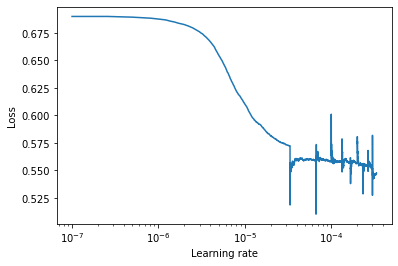

Medium  Elapsed time 7.19
MediumDropout


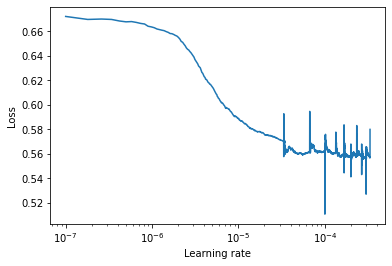

MediumDropout  Elapsed time 7.26
Medium_BN


AttributeError: module 'tensorflow.keras.layers' has no attribute 'batchNormalisation'

In [3]:
# for m in [modelBase,modelMedium,modelMedium_Dropout,modelLarge,modelLarge_Dropout,modelXLarge,modelXLarge_Dropout]:
for m in [modelMedium,modelMedium_Dropout,modelMedium_BN,modelMedium_BN_Dropout]:        
    start_time = time.time()
    print(m['name'])

    model = createCNN(m)
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),loss=tf.keras.losses.binary_crossentropy)
    
    lr_finder = LRFinder(min_lr=1e-7,max_lr=1e-4, steps_per_epoch=np.ceil(set_x.shape[0]/256), epochs=3)    

    model.fit(set_x, set_y
            ,batch_size = 256
            ,epochs= 10
            ,verbose=0
            ,callbacks=[lr_finder]
            )
    
    lr_finder.plot_loss()

    print(m['name']," Elapsed time", round((time.time() - start_time)/60,2))



Medium_BN


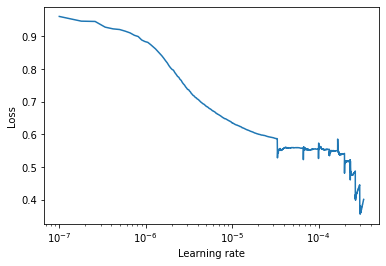

Medium_BN  Elapsed time 8.33
Medium_BN_Dropout


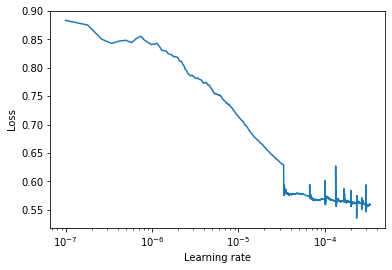

Medium_BN_Dropout  Elapsed time 8.39


In [3]:
# for m in [modelBase,modelMedium,modelMedium_Dropout,modelLarge,modelLarge_Dropout,modelXLarge,modelXLarge_Dropout]:
for m in [modelMedium_BN,modelMedium_BN_Dropout]:        
    start_time = time.time()
    print(m['name'])

    model = createCNN(m)
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),loss=tf.keras.losses.binary_crossentropy)
    
    lr_finder = LRFinder(min_lr=1e-7,max_lr=1e-4, steps_per_epoch=np.ceil(set_x.shape[0]/256), epochs=3)    

    model.fit(set_x, set_y
            ,batch_size = 256
            ,epochs= 10
            ,verbose=0
            ,callbacks=[lr_finder]
            )
    
    lr_finder.plot_loss()

    print(m['name']," Elapsed time", round((time.time() - start_time)/60,2))

## Experiments

* 8,16,32,64,128,256
* kernel size (7,7) 
* Dropout 0.05
* Batch normalization
* Batch Size 256
* Learning Rate 1e-3 (0.001)
* 20 files, 80K images
* 6 hours to train 400 epochs




In [3]:


for doRate in [0.05,0.2]:
    for lrnRate in [1e-3,1e-4,1e-5]:    

        start_time = time.time()
        print(start_time)

        experName = "CNNv2_Medium_RMSPropLR_" + str(lrnRate) + "_DropoutRate_" + str(doRate) #+"_KernelSize_" + str(ks) #
        print(experName)
        wandb.init(project="candlestick-CNN", name = experName )

        modelMedium_BN_Dropout['dropout'] = doRate

        model = createCNN(modelMedium_BN_Dropout)
        model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=lrnRate)
                        ,loss=tf.keras.losses.binary_crossentropy
                        ,metrics=[METRICS])

        history = model.fit(set_x, set_y
                            ,batch_size = 256
                            ,epochs=400
                            ,verbose=0
                            ,validation_data=(test_set_x,test_set_y)
                            ,validation_freq = 50
                            ,callbacks=[WandbCallback()]
                            )
        print("Elapsed time ", round((time.time() - start_time)/60,2))

1604404313.3808253
CNNv2_Medium_RMSPropLR_0.001_DropoutRate_0.05
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: amitagni (use `wandb login --relogin` to force relogin)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
Elapsed time  365.34
1604426233.5777032
CNNv2_Medium_RMSPropLR_0.0001_DropoutRate_0.05


epoch,399
loss,0.00732
precision,0.99515
recall,0.99449
auc,0.99969
_step,399
_runtime,21920
_timestamp,1604426233
val_loss,2.33671
val_precision,0.27884
val_recall,0.23444


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,███▆▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▃▁▅▆▇███████████████████████████████████
recall,▁▁▁▄▇███████████████████████████████████
auc,▁▁▃▆████████████████████████████████████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,▁▃▆▆▇█▇▇
val_precision,▁▅▇▆▃▅▄█
val_recall,█▃▆▁▁▃▁▅


KeyboardInterrupt: 

In [3]:
modelBase = {}
modelBase['name'] = 'Base'
modelBase['inputShape'] = (IMG_SIZE,IMG_SIZE,3)
modelBase['activation'] = 'relu'

modelBase['convLayerMultiplier'] = 1
modelBase['kernelSize'] = (7,7)

modelBase['poolingLayer'] = 'MaxPooling2D'
modelBase['poolSize'] = (2,2)
modelBase['padding'] = 'same'

modelBase['denseLayers'] = 2
modelBase['units'] = 128
modelBase['activation'] = 'relu'


#Medium
modelMedium = modelBase.copy()
modelMedium['name'] = 'Medium'
modelMedium['filters'] = [50,100,150,200]

#with Dropout and BN
modelMedium_BN_Dropout = modelMedium_Dropout.copy()
modelMedium_BN_Dropout['name'] = 'Medium_BN_Dropout'
modelMedium_BN_Dropout['batchnormalization'] = True




## Find LR that gives 0 loss quickly

In [5]:
for lrnRate in [1e-2,1e-3]:    
    
    start_time = time.time()
    print(start_time)

    experName = "CNNv2_FindLR_Medium_RMSPropLR_" + str(lrnRate) #+ "_DropoutRate_" + str(doRate) #+"_KernelSize_" + str(ks) #
    print(experName)
    wandb.init(project="candlestick-CNN", name = experName )

    # modelMedium_BN_Dropout['dropout'] = doRate

    model = createCNN(modelMedium)
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=lrnRate)
                    ,loss=tf.keras.losses.binary_crossentropy
                    ,metrics=[METRICS])

    history = model.fit(set_x, set_y
                        ,batch_size = 256
                        ,epochs=200
                        ,verbose=0
                        ,validation_data=(test_set_x,test_set_y)
                        ,validation_freq = 50
                        ,callbacks=[WandbCallback()]
                        )
    print("Elapsed time ", round((time.time() - start_time)/60,2))

1604441470.461869
CNNv2_FindLR_Medium_RMSPropLR_0.01
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: amitagni (use `wandb login --relogin` to force relogin)


KeyboardInterrupt: 